# About Dataset
## Source
Refer to Canada's website for the original wildfires data:
Forest Fires - Open Government Portal
Original license for the data:
Creative Commons 4.0 Attribution (CC-BY) license – Quebec

## About Dataset
This dataset contains satellite images (350x350px) in 2 classes :

- Wildfire : 22710 images
- No wildfire : 20140 images

The data was divided into train, test and validation with these percentages :

- Train : ~70%
- Test : ~15%
- Validation : ~15%
## How
Using Longitude and Latitude coordinates for each wildfire spot (> 0.01 acres burned) found on the dataset above we extracted satellite images of those areas using MapBox API to create a more convenient format of the dataset for **deep learning** and building a model that can **predict whether an area is at risk of a wildfire or not**

Binary Output - Fire or Not Fire - 1/0

# Import Packages

In [ ]:
! curl -L -o ~/autodl-tmp/wildfire-prediction-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/abdelghaniaaba/wildfire-prediction-dataset

! unzip ~/autodl-tmp/wildfire-prediction-dataset.zip -d ~/autodl-tmp/fire_data

In [2]:
# For Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# from tqdm.keras import TqdmCallback

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#  处理图片
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# 迁移学习
from tensorflow.keras.applications import Xception

# 加载被截断的图像
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# AUC, CM
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

ModuleNotFoundError: No module named 'tensorflow'

# Define Function

In [4]:
def set_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=0):
    set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# EDA function
def show_random_img(data_type_path : str, data_type : str):
  # print(f"{data_type}")
  plt.figure(figsize=(12, 12))
  classes = ['nowildfire', 'wildfire']

  for i,j in enumerate(classes):
    current_path = os.path.join(data_type_path, j)
    images = os.listdir(current_path)
    random_image_name = random.choice(images)
    random_image_path = os.path.join(current_path, random_image_name)
    img = load_img(random_image_path)
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{j} ({img.size[0]}x{img.size[1]})")

  plt.suptitle(f"{data_type}", y = 0.72, fontsize=20)
  plt.show()
  # print()

In [6]:
# EDA function
def show_dist(data_type_path : str, data_type : str):
  classes = ['nowildfire', 'wildfire']
  length = []

  for i, j in enumerate(classes):
    current_path = os.path.join(data_type_path, j)
    length.append(len(os.listdir(current_path)))

  norm = [round(float(i)/sum(length),2)*100 for i in length]

  ax = plt.bar(classes, norm)
  plt.bar_label(ax)
  plt.title(f"{data_type}")
  plt.show()

In [7]:
# Display the graph of chosen metric

def plot_metrics(hist, metric_train, metric_val) :
  fig = plt.figure(figsize=(5,5))
  plt.plot(hist.history[metric_train], color='teal', label=metric_train)
  plt.plot(hist.history[metric_val], color='orange', label=metric_val)
  fig.suptitle(metric_train, fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

In [8]:
def tunning_model(lr : float, ly : int, dropout : float, epochs : int):
    base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(128,128,3))

    base_model.trainable = False

    input = layers.Input(shape=(128,128,3))

    x = base_model(input, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    
    # parm
    if ly > 0:
        x = layers.Dense(ly, activation='relu')(x)
    
    # parm
    x = layers.Dropout(dropout)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model_transfer = keras.Model(input, output)

    # parm
    opt = keras.optimizers.Adam(learning_rate = lr)

    loss = keras.losses.BinaryCrossentropy()

    metrics = ['Recall',
               keras.metrics.AUC(curve = 'PR', name = 'pr_auc')]

    model_transfer.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)

    early_stopping = EarlyStopping(monitor= 'val_pr_auc', patience= 5, min_delta = 0.001)

    # tqdm_callback = TqdmCallback()
    
    print('Fitting...❗️')
    history = model_transfer.fit(
        train_generator,
    # parm
        epochs = epochs,
        validation_data = val_generator,
        verbose = 1,
        callbacks=[early_stopping]
    )
    print('Finished✅')
    return history

# Set Random Seed

In [9]:
set_global_determinism(seed=42)

# EDA

In [10]:
dataset_dir = "~/autodl-tmp/fire_data"
# dataset_dir = "./drive/MyDrive/Colab Notebooks/fire_data"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "valid")
test_dir = os.path.join(dataset_dir, "test")

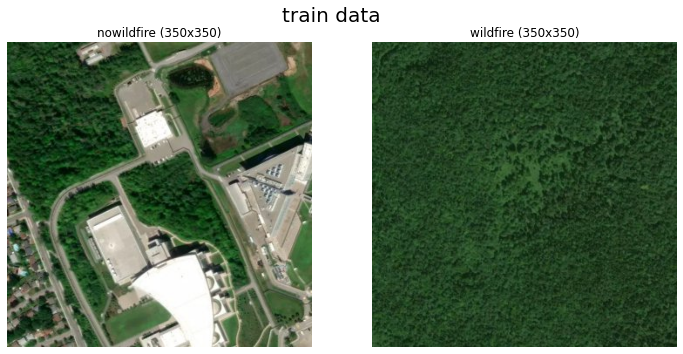

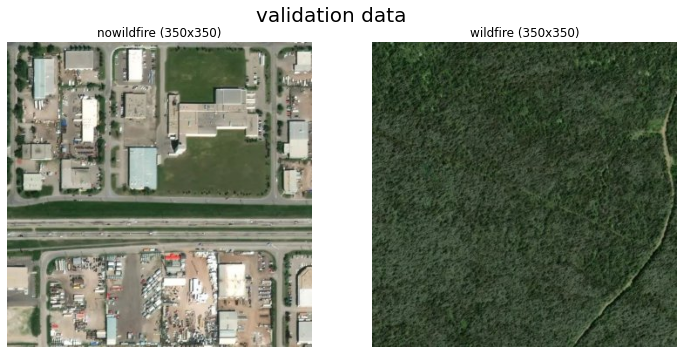

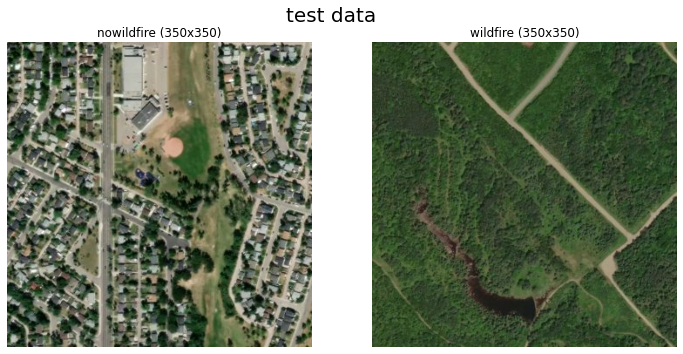

In [14]:
# Get a glance of images
show_random_img(train_dir, 'train data')
show_random_img(val_dir, 'validation data')
show_random_img(test_dir, 'test data')

Dataset Distribution


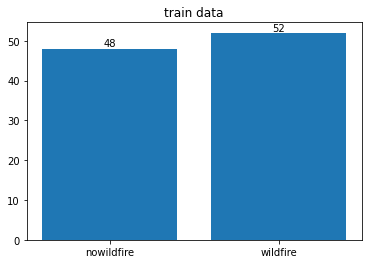

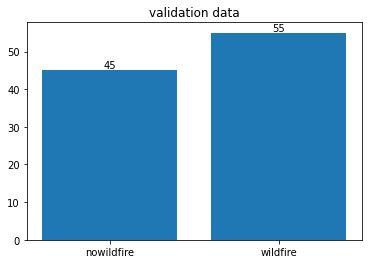

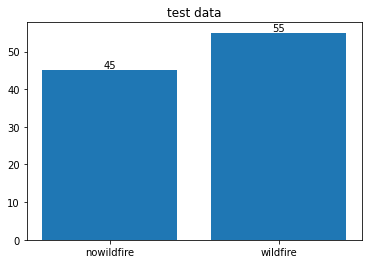

In [15]:
print('Dataset Distribution')
show_dist(train_dir, 'train data')
show_dist(val_dir, 'validation data')
show_dist(test_dir, 'test data')

# Image Processing

In [16]:
batch_size = 32

In [17]:
# Create preprocess parameter (No augumetation)
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# 从目录创建数据流 {'nowildfire': 0, 'wildfire': 1}
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle = True,
                                                    target_size = (128,128),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    shuffle = False,
                                                    target_size = (128,128),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Model Selection

## 1. Base Model

In [ ]:
# Model 1 : baseline Model
model = keras.Sequential()

model.add(layers.Input(shape = (128,128,3)))

# 第一层卷积
model.add(layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))

# 第二层卷积
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))

# 第三层卷积
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
# Adam优化
opt = keras.optimizers.Adam(learning_rate=0.0001)

# 编译
metrics = ['Recall',
           keras.metrics.AUC(curve="PR", name = "pr_auc")]

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=metrics)

In [ ]:
# 早停机制
early_stopping = EarlyStopping(monitor= 'val_pr_auc', patience=5, min_delta = 0.001)

# 进度跟踪
# tqdm_callback = TqdmCallback()

In [ ]:
# 开始拟合
print("Fitting...❗️")
history_1 = model.fit(
    train_generator,
    epochs=20,
    validation_data = val_generator,
    verbose = 1,
    callbacks=[early_stopping]
)
print('Finished!✅')

## 2. Base Model with Data Augmentation

In [ ]:
train_datagen_augm = ImageDataGenerator(rescale=1./255,
                                        # Augmentation parameters
                                        rotation_range=50,
                                        zoom_range = 0.1,
                                        brightness_range=[0.8, 1.2],
                                        horizontal_flip=True
                                        )

In [ ]:
train_generator_augm = train_datagen_augm.flow_from_directory(train_dir,
                                                              target_size=(128,128),
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              class_mode='binary')

In [ ]:
print("Fitting...❗️")
history_2 = model.fit(
    train_generator_augm,
    epochs=20,
    validation_data = val_generator,
    verbose = 1,
    callbacks=[early_stopping]
)
print('Finished!✅')

## 3. Transfet Learning Model (No augm)

In [ ]:
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(128,128,3))

base_model.trainable = False

input = layers.Input(shape=(128,128,3))

x = base_model(input, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_transfer = keras.Model(input, output)

model_transfer.summary(show_trainable=True)

In [9]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)

loss = keras.losses.BinaryCrossentropy()

metrics=['Recall', 
         keras.metrics.AUC(curve="PR", name = "pr_auc")]

model_transfer.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)

E0000 00:00:1758603034.746905   11743 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758603034.781757   11743 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


NameError: name 'model_transfer' is not defined

In [ ]:
early_stopping = EarlyStopping(monitor= 'val_pr_auc', patience= 5, min_delta = 0.001)

# tqdm_callback = TqdmCallback()

In [ ]:
print("Fitting...❗️")
history_3 = model_transfer.fit(
    train_generator,
    epochs=20,
    validation_data = val_generator,
    verbose = 1,
    callbacks=[early_stopping]
)
print('Finished!✅')

## Visualizing the results

In [ ]:
# Display the metrics of all models in the same graph

# List of history objects and labels
histories = [history_1, history_2, history_3]
labels = ['Model 1', 'Model 2', 'Model 3']

# Define metrics to plot
metrics = ['recall', 'pr_auc']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Plot training metric
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f'{labels[i]} Train')

    # Plot validation metric
    for i, hist in enumerate(histories):
        plt.plot(hist.history[f'val_{metric}'], linestyle='--', label=f'{labels[i]} Val')

    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

*Model 3 has a relative stable and resonable result*

# Model Tunning

## Search for the best learning rate for Adam optimizer

In [18]:
metrics = ['recall', 'pr_auc']

In [19]:
scores = {}

start=time.time()

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('########\n')
    print(lr)
    history = tunning_model(lr, ly = 0, dropout = 0.5, epochs = 20)
    scores[lr] = history.history
    print('########\n')

end=time.time()
print('程序运行时间为: %s Seconds'%(end-start))

########

0.0001


2025-09-22 11:25:30.005453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 11:25:30.762833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22167 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:16:00.0, compute capability: 8.9


Fitting...❗️
Epoch 1/20


2025-09-22 11:25:36.353303: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-09-22 11:25:37.247545: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-09-22 11:25:37.247571: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-09-22 11:25:37.247660: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


946/946 [==============================] - 106s 107ms/step - loss: 0.4534 - recall: 0.7730 - pr_auc: 0.8739 - val_loss: 0.3559 - val_recall: 0.9190 - val_pr_auc: 0.9370
Epoch 2/20
946/946 [==============================] - 99s 105ms/step - loss: 0.3452 - recall: 0.9232 - pr_auc: 0.9168 - val_loss: 0.3151 - val_recall: 0.9365 - val_pr_auc: 0.9466
Epoch 3/20
946/946 [==============================] - 101s 107ms/step - loss: 0.3186 - recall: 0.9356 - pr_auc: 0.9273 - val_loss: 0.2985 - val_recall: 0.9342 - val_pr_auc: 0.9540
Epoch 4/20
946/946 [==============================] - 98s 103ms/step - loss: 0.3011 - recall: 0.9394 - pr_auc: 0.9355 - val_loss: 0.2836 - val_recall: 0.9402 - val_pr_auc: 0.9567
Epoch 5/20
946/946 [==============================] - 98s 104ms/step - loss: 0.2941 - recall: 0.9396 - pr_auc: 0.9377 - val_loss: 0.2770 - val_recall: 0.9362 - val_pr_auc: 0.9603
Epoch 6/20
946/946 [==============================] - 95s 101ms/step - loss: 0.2858 - recall: 0.9416 - pr_auc: 0.9

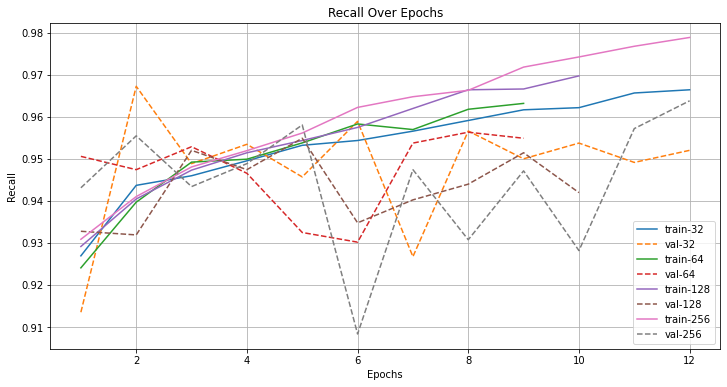

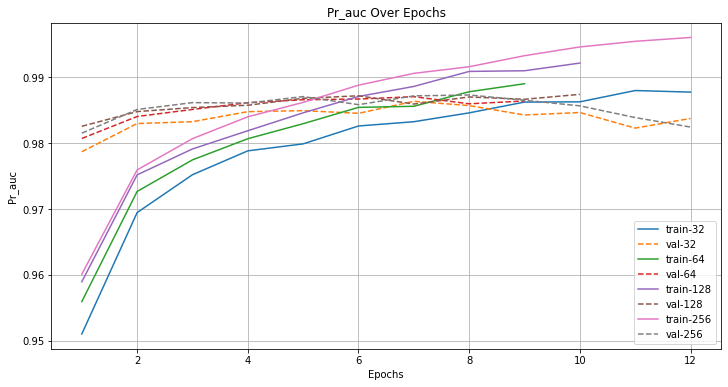

In [30]:
# Plot each metric and Evaluate
socres_lr = scores

for metric in metrics:
    plt.figure(figsize=(12, 6))

    for lr, history in socres.items():
        # Plot training metric
        plt.plot( range(1, len(history[f'{metric}'])+1 ), history[f'{metric}'], label = f'train-{lr}')
        # Plot validation metric
        plt.plot( range(1, len(history[f'val_{metric}'])+1), history[f'val_{metric}'], linestyle = '--', label = f'val-{lr}')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

*learning rate = 0.001 is good*

## Search for the best size for inner layer

In [24]:
scores = {}

start=time.time()

for ly in [32, 64, 128, 256]:
    print('########\n')
    print(ly)
    history = tunning_model(lr = 0.001, ly = ly , dropout = 0.5, epochs = 20)
    scores[ly] = history.history
    print('########\n')
    
end=time.time()
print('程序运行时间为: %s Seconds'%(end-start))

########

32
Fitting...❗️
Epoch 1/20
  3/946 [..............................] - ETA: 1:26 - loss: 0.6093 - recall: 0.1915 - pr_auc: 0.6603

2025-09-22 13:05:00.185423: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


946/946 [==============================] - 100s 104ms/step - loss: 0.2668 - recall: 0.9269 - pr_auc: 0.9510 - val_loss: 0.2168 - val_recall: 0.9135 - val_pr_auc: 0.9787
Epoch 2/20
946/946 [==============================] - 96s 102ms/step - loss: 0.2124 - recall: 0.9437 - pr_auc: 0.9694 - val_loss: 0.1828 - val_recall: 0.9672 - val_pr_auc: 0.9830
Epoch 3/20
946/946 [==============================] - 92s 97ms/step - loss: 0.1932 - recall: 0.9460 - pr_auc: 0.9752 - val_loss: 0.1679 - val_recall: 0.9489 - val_pr_auc: 0.9832
Epoch 4/20
946/946 [==============================] - 96s 101ms/step - loss: 0.1795 - recall: 0.9495 - pr_auc: 0.9788 - val_loss: 0.1616 - val_recall: 0.9534 - val_pr_auc: 0.9848
Epoch 5/20
946/946 [==============================] - 94s 100ms/step - loss: 0.1717 - recall: 0.9532 - pr_auc: 0.9799 - val_loss: 0.1615 - val_recall: 0.9457 - val_pr_auc: 0.9849
Epoch 6/20
946/946 [==============================] - 93s 98ms/step - loss: 0.1616 - recall: 0.9543 - pr_auc: 0.9826

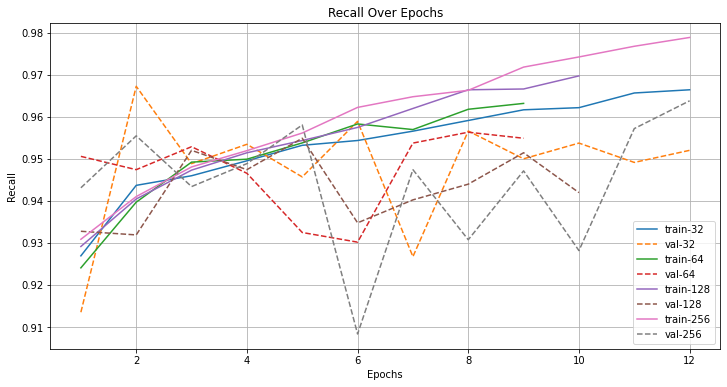

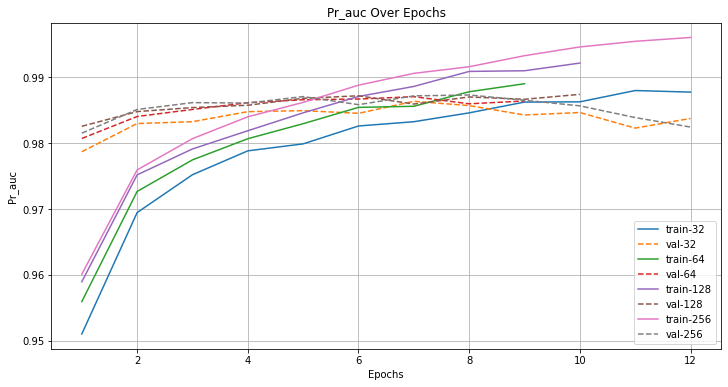

In [31]:
socres_ly = scores

# Plot each metric using Val Data
for metric in metrics:
    plt.figure(figsize=(12, 6))

    for ly, history in scores.items():
        # Plot training metric
        plt.plot(range(1,len(history[f'{metric}'])+1), history[f'{metric}'], label = f'train-{ly}')
        # Plot validation metric
        plt.plot(range(1,len(history[f'val_{metric}'])+1), history[f'val_{metric}'], linestyle='--', label = f'val-{ly}')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

*best inner layers number is 128*

## Search for the best drop rate

In [32]:
scores = {}

start=time.time()

for dropout in [0.0, 0.2, 0.5, 0.8]:
    print('########\n')
    print(dropout)
    history = tunning_model(lr = 0.001, ly = 128, dropout=dropout, epochs = 20)
    scores[dropout] = history.history
    print('########\n')

end=time.time()
print('程序运行时间为: %s Seconds'%(end-start))

########

0.0
Fitting...❗️
Epoch 1/20
946/946 [==============================] - 94s 96ms/step - loss: 0.2258 - recall: 0.9349 - pr_auc: 0.9647 - val_loss: 0.1807 - val_recall: 0.9261 - val_pr_auc: 0.9824
Epoch 2/20
946/946 [==============================] - 95s 101ms/step - loss: 0.1651 - recall: 0.9488 - pr_auc: 0.9812 - val_loss: 0.1583 - val_recall: 0.9420 - val_pr_auc: 0.9862
Epoch 3/20
946/946 [==============================] - 102s 108ms/step - loss: 0.1356 - recall: 0.9591 - pr_auc: 0.9867 - val_loss: 0.1868 - val_recall: 0.9129 - val_pr_auc: 0.9852
Epoch 4/20
946/946 [==============================] - 102s 108ms/step - loss: 0.1094 - recall: 0.9680 - pr_auc: 0.9911 - val_loss: 0.1527 - val_recall: 0.9647 - val_pr_auc: 0.9845
Epoch 5/20
946/946 [==============================] - 102s 108ms/step - loss: 0.0863 - recall: 0.9761 - pr_auc: 0.9945 - val_loss: 0.1568 - val_recall: 0.9428 - val_pr_auc: 0.9857
Epoch 6/20
946/946 [==============================] - 95s 100ms/step - loss:

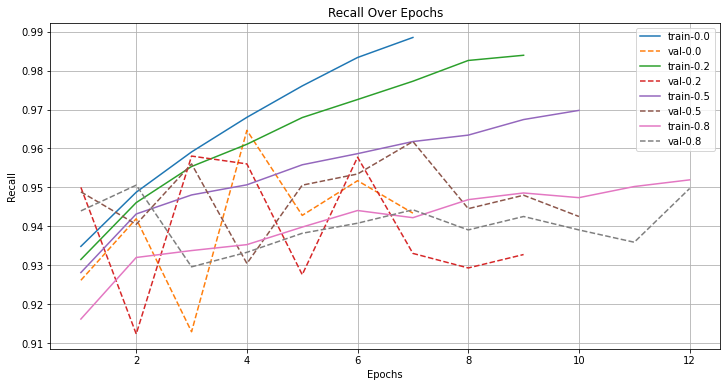

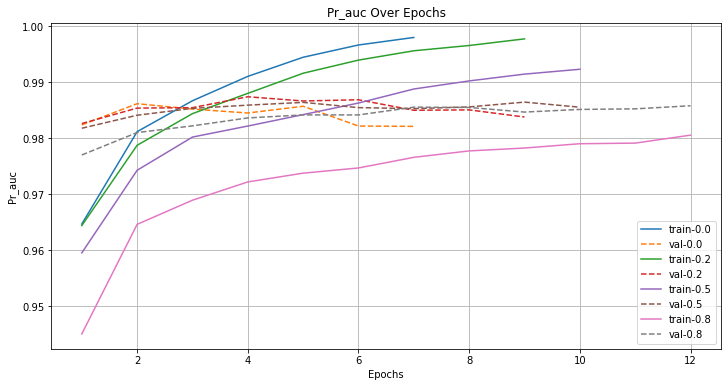

In [33]:
scores_dropout = scores

# Plot each metric using Val Data
for metric in metrics:
    plt.figure(figsize=(12, 6))

    for dropout, history in scores.items():
        # Plot training metric
        plt.plot(range(1,len(history[f'{metric}'])+1), history[f'{metric}'], label = f'train-{dropout}')
        # Plot validation metric
        plt.plot(range(1,len(history[f'val_{metric}'])+1) , history[f'val_{metric}'], linestyle='--',label = f'val-{dropout}')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

*drop out rate=0.2 is good*

# Final Model with Augmentation

In [34]:
train_datagen_augm = ImageDataGenerator(rescale=1./255,
                                        # Augmentation parameters
                                        rotation_range=50,
                                        zoom_range = 0.1,
                                        brightness_range=[0.8, 1.2],
                                        horizontal_flip=True
                                        )

In [35]:
train_generator_augm = train_datagen_augm.flow_from_directory(train_dir,
                                                              target_size=(128,128),
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              class_mode='binary')

Found 30250 images belonging to 2 classes.


In [36]:
# Create the Xception model
base_model = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128,3))

base_model.trainable = False

input = layers.Input(shape=(128,128,3))

x = base_model(input, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

x = layers.Dropout(0.2)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_transfer = keras.Model(input, output)

# 优化
opt = keras.optimizers.Adam(learning_rate = 0.001)

loss = keras.losses.BinaryCrossentropy()

metrics = ['Recall',
           keras.metrics.AUC(curve="PR", name = 'pr_auc')]

model_transfer.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)

early_stopping = EarlyStopping(monitor= 'val_pr_auc', mode = 'max', min_delta=0.001, patience= 5)

# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}.keras',
    save_best_only=True,
    monitor = 'val_pr_auc',
    mode='max'
)

print('Fitting...❗️')
history = model_transfer.fit(
    # augmentation
    train_generator_augm,
    epochs = 20,
    validation_data = val_generator,
    verbose = 1,
    callbacks=[early_stopping, checkpoint]
)
print('Finished✅')

Fitting...❗️
Epoch 1/20
946/946 [==============================] - 193s 202ms/step - loss: 0.2346 - recall: 0.9319 - pr_auc: 0.9628 - val_loss: 0.2196 - val_recall: 0.9316 - val_pr_auc: 0.9723
Epoch 2/20
946/946 [==============================] - 188s 198ms/step - loss: 0.1980 - recall: 0.9361 - pr_auc: 0.9730 - val_loss: 0.2163 - val_recall: 0.9063 - val_pr_auc: 0.9791
Epoch 3/20
946/946 [==============================] - 184s 195ms/step - loss: 0.1822 - recall: 0.9422 - pr_auc: 0.9777 - val_loss: 0.1861 - val_recall: 0.9514 - val_pr_auc: 0.9779
Epoch 4/20
946/946 [==============================] - 183s 194ms/step - loss: 0.1749 - recall: 0.9453 - pr_auc: 0.9795 - val_loss: 0.1946 - val_recall: 0.9353 - val_pr_auc: 0.9784
Epoch 5/20
946/946 [==============================] - 187s 197ms/step - loss: 0.1694 - recall: 0.9470 - pr_auc: 0.9805 - val_loss: 0.1726 - val_recall: 0.9486 - val_pr_auc: 0.9810
Epoch 6/20
946/946 [==============================] - 187s 198ms/step - loss: 0.1682 - 

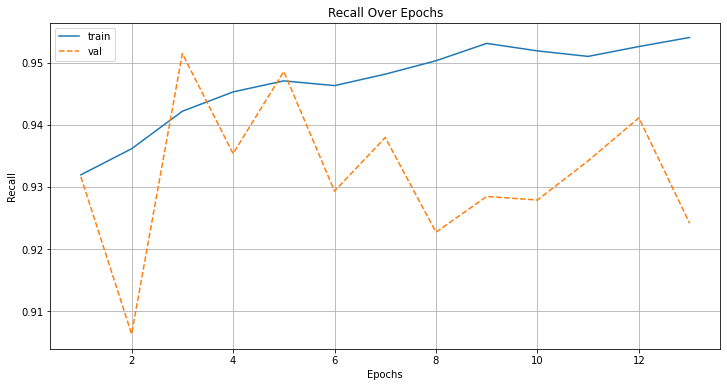

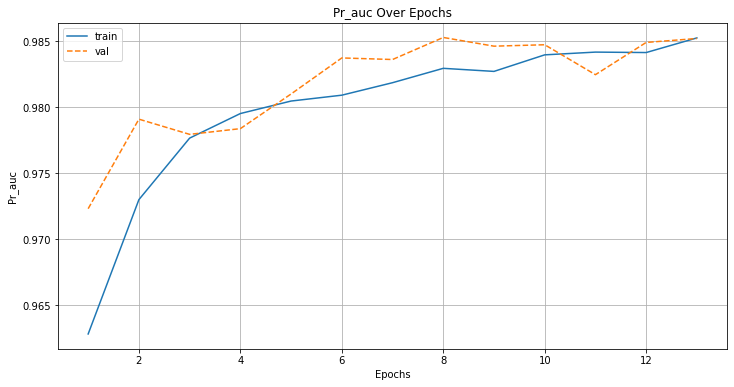

In [38]:
# Define metrics to plot
metrics = ['recall', 'pr_auc']

# Plot each metric using Val Data
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Plot training metric
    plt.plot( range(1, len(history.epoch)+1) , history.history[f'{metric}'], label = f'train')
    # Plot validation metric
    plt.plot( range(1, len(history.epoch)+1) , history.history[f'val_{metric}'], linestyle='--',label = f'val')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Model Test

In [75]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    shuffle = False,
                                                    target_size = (128,128),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')

Found 6300 images belonging to 2 classes.


In [3]:
model = keras.models.load_model('./xception_v1_08.keras')

2025-09-23 11:02:53.139725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 11:02:53.819768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22167 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:39:00.0, compute capability: 8.9


In [77]:
# 确保测试生成器重置，以获得确定性的数据顺序，这非常重要
# 因为它保证了预测值和真实标签是严格对应的
test_generator.reset()

test_results = model.evaluate(test_generator, verbose = 1)

print("\ntest result:")
print(f"Loss: {test_results[0]:.3f}")
print(f"Recall: {test_results[1]:.3f}")
print(f"PR AUC: {test_results[2]:.3f}")

197/197 [==============================] - 18s 81ms/step - loss: 0.1628 - recall: 0.9267 - pr_auc: 0.9883

test result:
Loss: 0.163
Recall: 0.927
PR AUC: 0.988


In [78]:
#按照生成器的数据顺序获取模型的预测结果 (probability)
y_pred_probs = model.predict(test_generator).flatten()

# 获取真实标签
y_true = test_generator.classes

197/197 [==============================] - 17s 81ms/step


Test PR-AUC: 0.9885503326406948


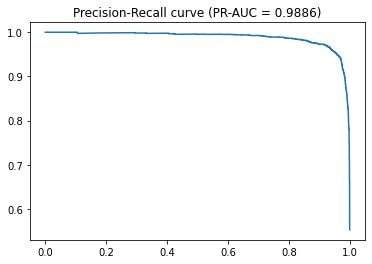

In [86]:
# 计算和绘制PRAUC曲线
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall, precision)
print(f"Test PR-AUC: {pr_auc}")

plt.plot(recall, precision)
plt.title(f'Precision-Recall curve (PR-AUC = {pr_auc:.4f})')
plt.show()

Optimal threshold based on PR curve: 0.249


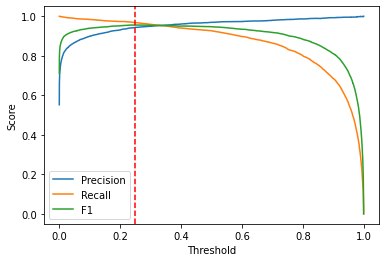

In [85]:
# 寻找使F1最大化的点
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on PR curve: {optimal_threshold:.3f}")

# 可视化阀值
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')
plt.axvline(x=optimal_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

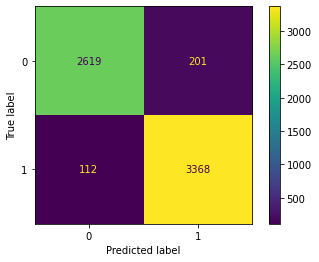

In [91]:
# output real class [0,1]
y_pred_classes = (y_pred_probs > optimal_threshold).astype(int)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [94]:
# classification_report提供了精确率、召回率和F1分数等关键指标
report = classification_report(y_true, y_pred_classes, target_names=["No Wildfire", "Wildfire"])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.96      0.93      0.94      2820
    Wildfire       0.94      0.97      0.96      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



# Deployment

In [ ]:
# Convert to TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

model_tflite = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp2wqfgl19/assets


INFO:tensorflow:Assets written to: /tmp/tmp2wqfgl19/assets
2025-09-23 11:03:21.374087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-09-23 11:03:21.374149: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-09-23 11:03:21.375105: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp2wqfgl19
2025-09-23 11:03:21.407001: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2025-09-23 11:03:21.407038: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp2wqfgl19
2025-09-23 11:03:21.579974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-09-23 11:03:21.607691: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2025-09-23 11:03:22.290616: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

In [ ]:
! pip install keras-image-helper
! pip install tflite-runtime

In [ ]:
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

In [ ]:
# Predict
# Load the LiteRT model and allocate tensors.
interpreter = tflite.Interpreter(model_path="./fire_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

preprocessor = create_preprocessor('xception', target_size=(128,128))
X = preprocessor.from_path('./img.jpg')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
interpreter.set_tensor(input_details[0]['index'], X)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [4]:
dict(zip(['probability'], output_data[0].tolist() ))

{'probability': 0.99074847}

# Pipenv

In [1]:
# ! pip install pipenv
! pipenv install tensorflow==2.9 numpy scikit-learn pillow flask tflite-runtime keras-image-helper flasgger datetime
# ! pipenv shell

To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Installing tensorflow==2.9...
✔ Installation Succeeded
Installing numpy...
✔ Installation Succeeded
Installing scikit-learn...
✔ Installation Succeeded
Installing pillow...
✔ Installation Succeeded
Installing flask...
✔ Installation Succeeded
Installing tflite-runtime...
✔ Installation Succeeded
Installing keras-image-helper...
✔ Installation Succeeded
Installing flasgger...
✔ Installation Succeeded
Installing datetime...
✔ Installation Succeeded
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Installing dependencies from Pipfile.lock (c3d67f)...
All dependencies are now up-to-date!
Upgrading tensorflow==2.9, numpy, scikit-learn, pillow, flask, tflite-runtime, 
keras-image-helper, flasgger, datetime in  dependencies.
Building requirements...
Resolving dependencies....
✔ Success! Locking 

# Docker

In [ ]:
! docker build -t ml-capstone .

! docker rmi -f $(docker images -aq)

! docker run -it --rm -p 9696:9696 ml-capstone:latest